In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import matplotlib.image as mpimg #for image reading
import csv                       #for csv reading
from matplotlib import colors

try:
    import QOL.plots as pqol #custom plotting stuff for Sam
    pqol.fixfigsize((1,1))
    pqol.scale_fonts((2,2))
except:
    print('pqol not loaded, defaulting to matplotlib.pyplot.')
    pqol=plt

import ImageProcessing as ip #ProjectOAK file with image processing functions.
import  DataProcessing as dp #ProjectOAK file with data  processing functions.
#''' #comment this line if actively editting ImageProcessing.py, to force reloads.
from importlib import reload 
reload(ip)
reload(dp)
#''';

CSVFILE = dp.CSVFILE2
IMAGESFOLDER = dp.IMAGESFOLDER2J

In [2]:
## get data from csv file about pokemon.
csvdata, cc = dp.read_csv(dp.CSVFILE2)

Took  0.01 seconds to read data from dataset/Pokedex_Ver6.csv


In [3]:
# some examples of convenient functions from DataProcessing, to help interact with the data:
print('>1>)',dp.poke_to_N('Charizard', csvdata))
print('>2>)',dp.N_to_poke(6, csvdata, code=1)) #can pass numbers as number or str(number).
print('>3>)',dp.N_to_poke(6, csvdata))
print('>4>)',dp.N_to_S(6, csvdata))
print('>5>)',dp.S_to_poke(61, csvdata))
print('>6>)',dp.S_to_N(61, csvdata))
print('>7>)',dp.poke_to_S('Charizard', csvdata))
#note that serial number = pokemon number + code, and code=1 for base forms of pokemon (the usual forms you are used to).

>1>) 6
>2>) Charizard
>3>) ['Charizard' 'Mega Charizard X' 'Mega Charizard Y']
>4>) ['61' '62' '63']
>5>) Charizard
>6>) 6
>7>) 61


In [4]:
# some examples which demonstrate more precise ways to interact with this data:
print('>1>)', cc)
print('')
print('>2>)', cc._asdict())
print('')
print('>3>)', csvdata.shape)
print('')
row = np.where(csvdata=='Pikachu')[0][0]
print('>4>)', csvdata[row])                #the entire row for row=row
print('')
print('>5>)', csvdata[row,cc.NUMBER], csvdata[row,cc.SERIAL], csvdata[row,cc.TYPE1]) #NUMBER, SERIAL, and TYPE1 for row=row
print('')
print('>6>)', csvdata[:,cc.NUMBER])        #the entire column for column=cc.NUMBER; i.e. all the info about pokemon NUMBERs.
print('')
print('>7>)', csvdata[:,cc.NAME])          #the entire column for column=cc.NAME;   i.e. all the info about pokemon NAMEs.

>1>) indices(NUMBER=0, CODE=1, SERIAL=2, NAME=3, TYPE1=4, TYPE2=5, COLOR=6, ABILITY1=7, ABILITY2=8, ABILITY_HIDDEN=9, GENERATION=10, LEGENDARY=11, MEGA_EVOLUTION=12, HEIGHT=13, WEIGHT=14, HP=15, ATK=16, DEF=17, SP_ATK=18, SP_DEF=19, SPD=20, TOTAL=21)

>2>) OrderedDict([('NUMBER', 0), ('CODE', 1), ('SERIAL', 2), ('NAME', 3), ('TYPE1', 4), ('TYPE2', 5), ('COLOR', 6), ('ABILITY1', 7), ('ABILITY2', 8), ('ABILITY_HIDDEN', 9), ('GENERATION', 10), ('LEGENDARY', 11), ('MEGA_EVOLUTION', 12), ('HEIGHT', 13), ('WEIGHT', 14), ('HP', 15), ('ATK', 16), ('DEF', 17), ('SP_ATK', 18), ('SP_DEF', 19), ('SPD', 20), ('TOTAL', 21)])

>3>) (1052, 22)

>4>) ['25' '1' '251' 'Pikachu' 'Electric' '' 'Yellow' 'Static' ''
 'Lightning Rod' '1' '0' '0' '0.4' '6' '35' '55' '40' '50' '50' '90' '320']

>5>) 25 251 Electric

>6>) ['1' '2' '3' ... '898' '898' '898']

>7>) ['Bulbasaur' 'Ivysaur' 'Venusaur' ... 'Calyrex' 'Calyrex' 'Calyrex']


## Get all the images of pokemon!

In [5]:
allimages = ip.get_all_images(dp.IMAGESFOLDER2J)

got all 819 images in   1.1 seconds (from folder = dataset/images/archive/pokemon_jpg/pokemon_jpg)


In [6]:
#the image names from this folder are numeric, or numeric + extra info.
examples = np.s_[:7]
imagekeys = np.array(list(allimages.keys()))
print('imagefile names (examples):',imagekeys[examples]) #some examples.

imagefile names (examples): ['63' '189' '6-mega-y' '77' '638' '604' '162']


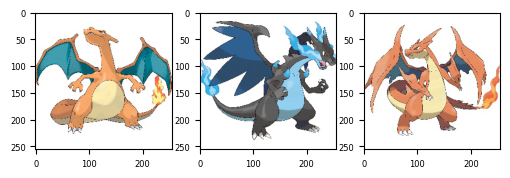

In [7]:
#for example, we can have a look at some of the images:
fig, axs = plt.subplots(1,3, figsize=(6,2))
plt.sca(axs[0]); plt.imshow(allimages['6'])
plt.sca(axs[1]); plt.imshow(allimages['6-mega-x'])
plt.sca(axs[2]); plt.imshow(allimages['6-mega-y'])
plt.show()

In [8]:
#let's convert these numbers to serial numbers. (code=1 takes the base forms, only.)
seris = np.array(dp.Ns_to_S(imagekeys, csvdata, code=1))    #serial numbers
print('serial numbers (examples):',seris[examples]) #some examples.

serial numbers (examples): ['631' '1891' '' '771' '6381' '6041' '1621']


In [9]:
#you'll notice that the non-numeric image names became empty strings.
#let's use that, and exclude non-numeric things for now. (We can process them later to add more data.)
idx_include = (seris != '')
print('idx_include (examples):',idx_include[examples]) #some examples.

idx_include (examples): [ True  True False  True  True  True  True]


In [10]:
#we can now figure out which rows these correspond to in the csv, and index by those.
used_rows = np.array(dp.vectorized_row_where(seris[idx_include], csvdata, cc.SERIAL))
#for example:
print('some examples which will be included:\n',
      csvdata[used_rows[examples]][:,[cc.NUMBER, cc.SERIAL, cc.NAME, cc.TYPE1]])

some examples which will be included:
 [['63' '631' 'Abra' 'Psychic']
 ['189' '1891' 'Jumpluff' 'Grass']
 ['77' '771' 'Ponyta' 'Fire']
 ['638' '6381' 'Cobalion' 'Steel']
 ['604' '6041' 'Eelektross' 'Electric']
 ['162' '1621' 'Furret' 'Normal']
 ['176' '1761' 'Togetic' 'Fairy']]


You can see that the non-numeric things are excluded:
> imagefile names (examples): ['63' '189' '77' '638' '604' '162' '176']
> serial numbers (examples): ['631' '1891' '771' '6381' '6041' '1621' '1761']
> pokemon names (examples): ['Abra' 'Jumpluff' 'Ponyta' 'Cobalion' 'Eelektross' 'Furret' 'Togetic']
> pokemon type1s (examples): ['Psychic' 'Grass' 'Fire' 'Steel' 'Electric' 'Normal' 'Fairy']
And we can check the indexing was done properly by plotting some examples:


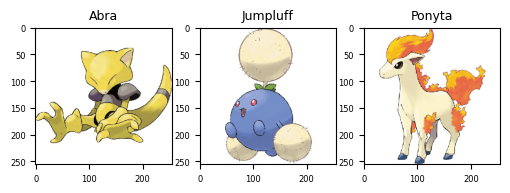

In [11]:
used_pokes  = csvdata[used_rows, cc.NAME]
used_types  = csvdata[used_rows, cc.TYPE1]
used_seris  = seris[idx_include] # == csvdata[used_rows, cc.SERIAL]
used_imagekeys = imagekeys[idx_include]
used_images = np.array([allimages[key] for key in used_imagekeys])
print('You can see that the non-numeric things are excluded:')
print('> imagefile names (examples):',used_imagekeys[examples])
print('> serial numbers (examples):',used_seris[examples])
print('> pokemon names (examples):',used_pokes[examples])
print('> pokemon type1s (examples):',used_types[examples])
print('And we can check the indexing was done properly by plotting some examples:')
fig, axs = plt.subplots(1,3, figsize=(6,2))
plt.sca(axs[0]); plt.imshow(used_images[0]); plt.title(used_pokes[0])
plt.sca(axs[1]); plt.imshow(used_images[1]); plt.title(used_pokes[1])
plt.sca(axs[2]); plt.imshow(used_images[2]); plt.title(used_pokes[2])
plt.show()

# Compile data into single place for convenience

In [12]:
# convert labels to integers before using.
used_labels = dp.type_to_idx(used_types)
print('types as integers (examples):', used_labels[examples])
print('convert them back (examples):', dp.idx_to_type(used_labels[examples]))

types as integers (examples): [14  9  6 16  3 12  4]
convert them back (examples): ['Psychic' 'Grass' 'Fire' 'Steel' 'Electric' 'Normal' 'Fairy']


In [13]:
dd = dp.Full_Dataset(used_images, used_labels, serials=csvdata[used_rows][:,[cc.NAME, cc.SERIAL]], val_size=0.2)
print('train_size: ', dd.train_size, ', val_size: ', dd.val_size, ', test_size: ', dd.test_size, sep='')

| setting: train_data     | setting: val_data       | setting: test_data      
| setting: train_labels   | setting: val_labels     | setting: test_labels    
| setting: train_serials  | setting: val_serials    | setting: test_serials   
scaling data
Took  5.17 seconds to scale data
train_size: 493, val_size: 140, test_size: 70


In [14]:
# TODO: show some examples here of how to use this dataset object 'dd'.

In [15]:
IMAGESHAPE = dd.train_data[0].shape
print("shape of images:",IMAGESHAPE)

shape of images: (256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


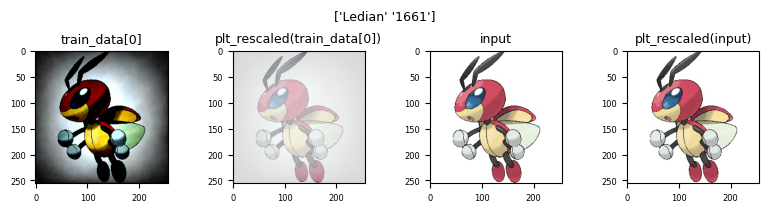

In [16]:
#example which shows data is loaded properly; also shows scaling.
fig, axs = plt.subplots(1,4, figsize=(8,2))
ii = 0
scaled_im = dd.train_data[ii]  #data might not fall in [0..1].
input_im  = dd.data_input[dd.argsplit['train'][ii]]
plt.suptitle(str(dd.train_serials[ii]))
plt.sca(axs[0]); plt.imshow(scaled_im);      plt.title('train_data[{:d}]'.format(ii))
plt.sca(axs[1]); ip.plt_rescaled(scaled_im); plt.title('plt_rescaled(train_data[{:d}])'.format(ii))
plt.sca(axs[2]); plt.imshow(input_im);       plt.title('input')
plt.sca(axs[3]); ip.plt_rescaled(input_im);  plt.title('plt_rescaled(input)')
plt.tight_layout()
plt.show()
#note plt_rescaled does nothing to images which span [0..1]; otherwise scales image to use full domain [0..1].
#     plt_rescaled does a linear transformation to the image data. (add constant, multiply by constant.)

## Single-type classification (the simplest problem)

In [17]:
## let's first make a single-label neural network which only assigns one type per pokemon.
# This is most similar to what we've done already.
# I think it should just ignore the info about secondary types.

# use: https://www.tensorflow.org/guide/data#reading_input_data to read inputs.


In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

### set up model

In [19]:
def create_CNN():
    num_classes = dp.NTYPES+1

    model = models.Sequential()
    model.add(layers.Conv2D(3, (3,3), input_shape = IMAGESHAPE))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes * 2, activation = 'relu'))
    model.add(layers.Dense(num_classes, activation = 'softmax'))

    model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
     metrics = ['accuracy'])


    # model = models.Sequential()
    # model.add(layers.Conv2D(10, (2,2), activation='relu', input_shape=IMAGESHAPE))
    # model.add(layers.MaxPooling2D((3, 3)))
    # model.add(layers.Conv2D(20, (2,2), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(40, (2,2), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(100, activation='relu'))
    # model.add(layers.Dense(NTYPES, activation='softmax'))


    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"),
    #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #               metrics=['sparse_categorical_accuracy'])
    # model.compile(optimizer=tf.keras.optimizers.RMSprop(),
    #               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #               metrics=['sparse_categorical_accuracy'])
    #model.summary()
    return model

In [20]:
epochs = 15
batch_size = 32
verbose = 1

model = create_CNN()

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
history = model.fit(dd.train_data, dd.train_labels, validation_data=(dd.val_data, dd.val_labels),
                      batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=[callback])

# train the data for 500 epochs
#model.fit(data_train, labels_train, batch_size = 32, epochs = 500, verbose=1, validation_split = 0.1)
#model.evaluate(dd['val']['data'], dd['val']['labels'])

Epoch 1/15
16/16 [==============================] - 3s 184ms/step - loss: 2.8938 - accuracy: 0.1400 - val_loss: 2.8626 - val_accuracy: 0.1571
Epoch 2/15
16/16 [==============================] - 3s 169ms/step - loss: 2.7961 - accuracy: 0.2292 - val_loss: 2.8605 - val_accuracy: 0.1714
Epoch 3/15
16/16 [==============================] - 3s 169ms/step - loss: 2.7405 - accuracy: 0.3002 - val_loss: 2.8455 - val_accuracy: 0.1714
Epoch 4/15
16/16 [==============================] - 3s 172ms/step - loss: 2.6947 - accuracy: 0.3428 - val_loss: 2.8450 - val_accuracy: 0.1786
Epoch 5/15
16/16 [==============================] - 3s 169ms/step - loss: 2.6199 - accuracy: 0.4320 - val_loss: 2.8554 - val_accuracy: 0.2000
Epoch 6/15
16/16 [==============================] - 3s 169ms/step - loss: 2.5531 - accuracy: 0.4929 - val_loss: 2.8707 - val_accuracy: 0.1643
Epoch 7/15
16/16 [==============================] - 3s 169ms/step - loss: 2.5072 - accuracy: 0.5294 - val_loss: 2.8941 - val_accuracy: 0.1286


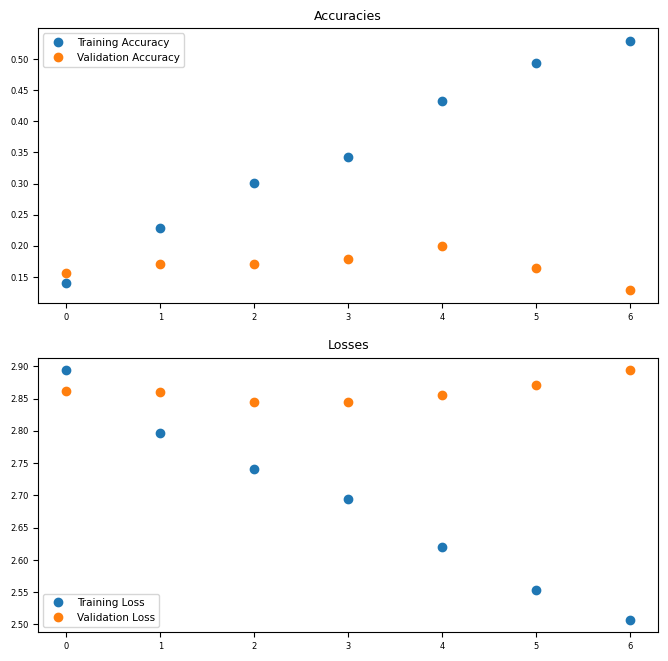

Maximum validation accuracy achieved: 0.20000000298023224


In [21]:
epochs = len(history.history['loss'])

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(epochs), history.history['accuracy'], 'o', label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], 'o', label='Validation Accuracy')
plt.legend()
plt.title('Accuracies')

plt.subplot(2, 1, 2)
plt.plot(range(epochs), history.history['loss'], 'o', label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], 'o', label='Validation Loss')
plt.legend()
plt.title('Losses')
plt.show()

print("Maximum validation accuracy achieved: " + str(np.max(history.history['val_accuracy'])))

prediction (validation data)


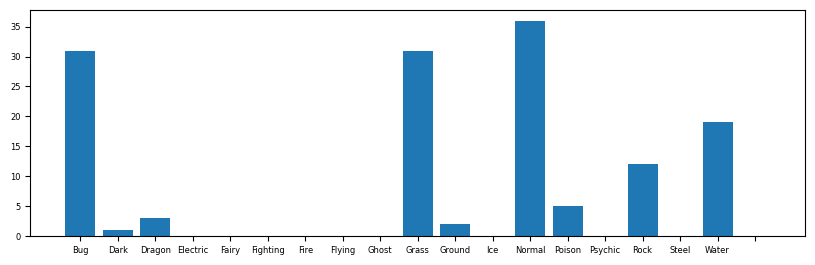

data (validation data)


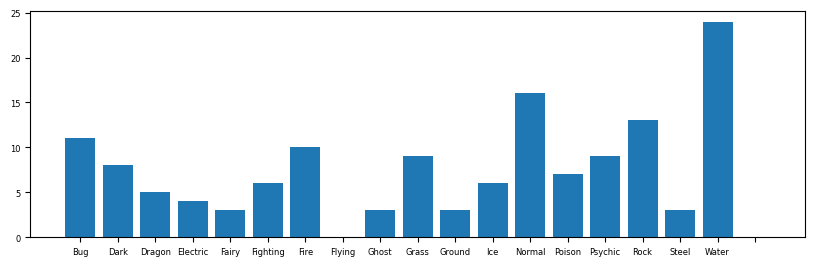

In [22]:
#predictions = onehot_to_i(model.predict(dd['val']['data']))
predictions = dp.prediction_to_idx(model.predict(dd.val_data)) #prediction = type with max probability.
assert len(predictions)==len(dd.val_data)
print('prediction (validation data)')
plt.figure(figsize=(10,3))
bc_p = np.bincount(predictions, minlength=dp.NTYPES+1)
plt.bar(dp.ALLTYPES, bc_p);
plt.show()
print('data (validation data)')
plt.figure(figsize=(10,3))
bc_s = np.bincount(dd.val_labels, minlength=dp.NTYPES+1)
plt.bar(dp.ALLTYPES, bc_s);
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

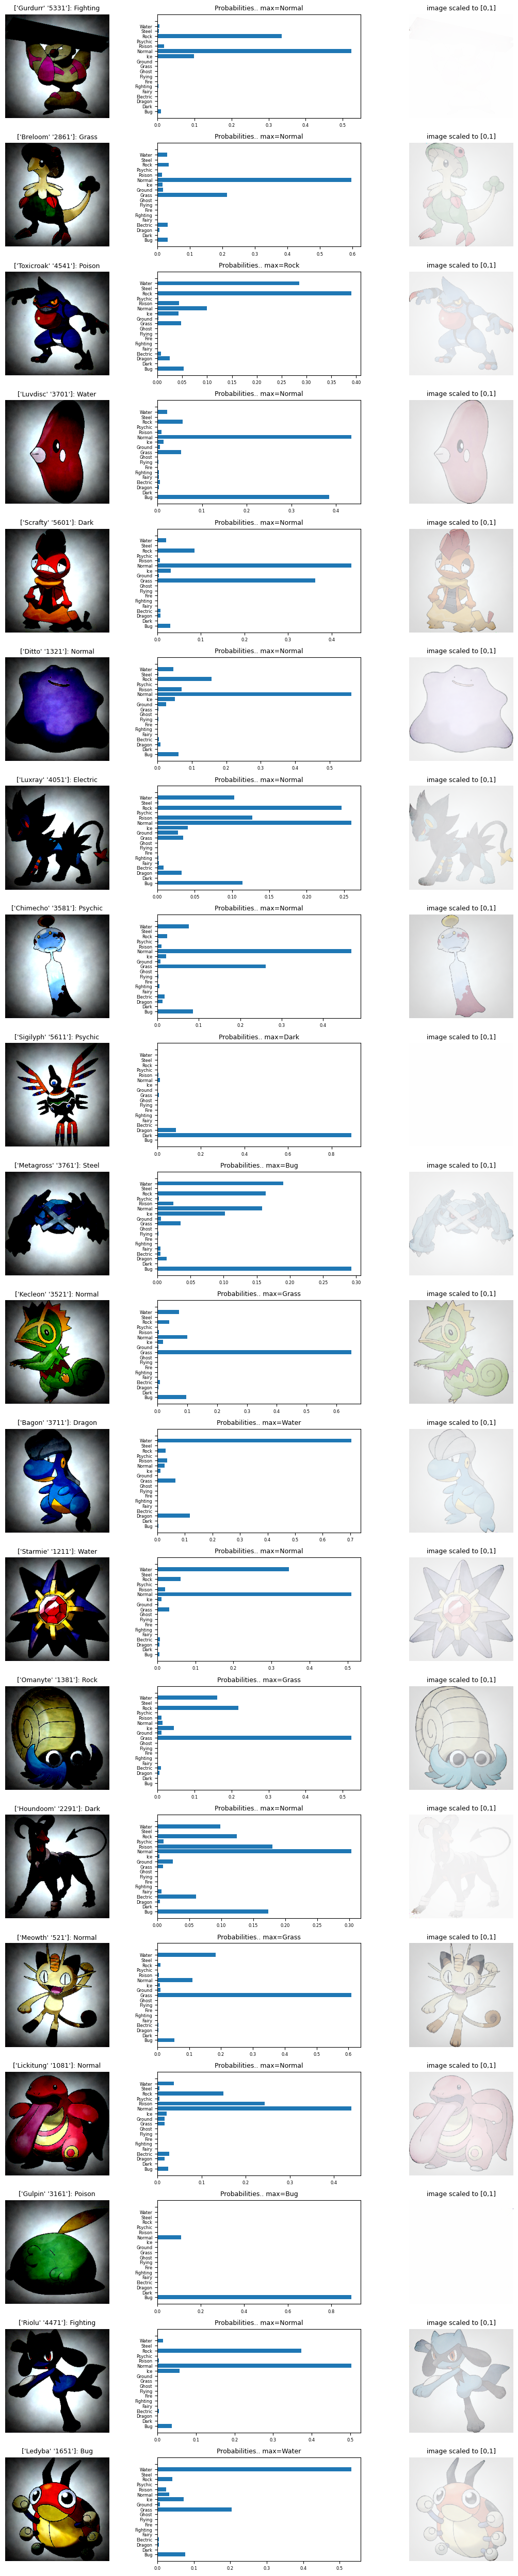

In [26]:
istart = 0
istop  = 20
NSAMPLES = istop - istart
slicer = np.s_[istart:istop]

imgs = dd.val_data[slicer]
lbls = dd.val_labels[slicer]
nms  = dd.val_serials[slicer]
predictions = model.predict(imgs)
fig, axs = plt.subplots(NSAMPLES, 3, figsize=[12, 2.5*NSAMPLES])
for i in range(NSAMPLES):
    plt.sca(axs[i][0])
    plt.imshow(imgs[i])
    arr = np.array(lbls[i])
    index = np.where(arr == 1)
    plt.title(str(nms[i])+': '+str(dp.idx_to_type(lbls[i])))
    plt.axis("off")

    plt.sca(axs[i][1])
    plt.title("Probabilities.. max="+str(dp.idx_to_type(dp.prediction_to_idx(predictions[i]))))
    plt.barh(dp.ALLTYPES, predictions[i])
    
    plt.sca(axs[i][2])
    ip.plt_rescaled(imgs[i])
    plt.title('image scaled to [0,1]')
    plt.axis("off")
    
plt.tight_layout()

## Multi-label classification (a non-trivial generalization?)

In [24]:
## We want to have images be assigned two labels (the second label possibly being 'None').
# apparently this problem (of assigning multiple labels) is known more generally as 'Multi-label classification'.
# it might be nontrivial.

## Some thoughts:
# - I think it will be cool to see if including two labels actually leads to improvements on accuracy...
# - I feel like usually type1 and type2 are correlated (e.g. more likely to get a grass+poison poke than grass+fire).
#    I wonder how we can incorporate these correlations, or if we should even incorporate them at all.
#    Would a neural network be able to learn these correlations?